# Train, Evaluate and Tune Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ternary
from sklearn import datasets as skdatasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
import time

## Data Preprocessing

In [2]:
# load iris dataset
iris = skdatasets.load_iris()
X = iris.data
y = iris.target

In [3]:
# shuffle and split training and evaluation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=0)

## 1st Approach: PCA + Logistic Regression

#### Training

In [4]:
# PCA with 2 components
pca = PCA(n_components=2).fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)

# logistic regression
clf = LogisticRegression(solver="lbfgs", multi_class="auto").fit(X_train_pca, y_train)

In [5]:
# predicitons and probabilities
y_train_preds = clf.predict(X_train_pca)
y_train_probs = clf.predict_proba(X_train_pca)

# print traing socres
print("Training:")
print("    accuracy: %.4f" % accuracy_score(y_train, y_train_preds))
print("    macro-f1 score: %.4f" % f1_score(y_train, y_train_preds, average="macro"))
print("    micro-f1 score: %.4f" % f1_score(y_train, y_train_preds, average="micro"))
print("    area uder ROC curve: %.4f" % roc_auc_score(y_train, y_train_probs, average="macro", multi_class="ovo"))

# save traing scores
with open("model-pca-logistic.txt", "w") as f:
    f.write("Model: PCA (n=2) + Logistic Regression\n")
    f.write("Training size: %d\n" % X_train.shape[0])
    f.write("Evaluating size: %d\n\n" % X_val.shape[0])
    f.write("Training:\n")
    f.write("    accuracy: %.4f\n" % accuracy_score(y_train, y_train_preds))
    f.write("    macro-f1 score: %.4f\n" % f1_score(y_train, y_train_preds, average="macro"))
    f.write("    micro-f1 score: %.4f\n" % f1_score(y_train, y_train_preds, average="micro"))
    f.write("    area uder ROC curve: %.4f\n\n" % roc_auc_score(y_train, y_train_probs, average="macro", multi_class="ovo"))

Training:
    accuracy: 0.9619
    macro-f1 score: 0.9621
    micro-f1 score: 0.9619
    area uder ROC curve: 0.9981


#### Evaluating

In [6]:
# predicitons and probabilities
y_val_preds = clf.predict(X_val_pca)
y_val_probs = clf.predict_proba(X_val_pca)

# print evaluating socres
print("Evaluating:")
print("    accuracy: %.4f" % accuracy_score(y_val, y_val_preds))
print("    macro-f1 score: %.4f" % f1_score(y_val, y_val_preds, average="macro"))
print("    micro-f1 score: %.4f" % f1_score(y_val, y_val_preds, average="micro"))
print("    area uder ROC curve: %.4f" % roc_auc_score(y_val, y_val_probs, average="macro", multi_class="ovo"))

# save evaluating scores
with open("model-pca-logistic.txt", "a") as f:
    f.write("Evaluating:\n")
    f.write("    accuracy: %.4f\n" % accuracy_score(y_train, y_train_preds))
    f.write("    macro-f1 score: %.4f\n" % f1_score(y_train, y_train_preds, average="macro"))
    f.write("    micro-f1 score: %.4f\n" % f1_score(y_train, y_train_preds, average="micro"))
    f.write("    area uder ROC curve: %.4f\n" % roc_auc_score(y_train, y_train_probs, average="macro", multi_class="ovo"))

Evaluating:
    accuracy: 0.9778
    macro-f1 score: 0.9760
    micro-f1 score: 0.9778
    area uder ROC curve: 0.9949


#### Evaluation Plots

In [7]:
# setting sizes and boundaries
figsizex = 8
figsizey = 6
res = 10
xmin, ymin = X_val_pca.min(axis=0) - 0.5
xmax, ymax = X_val_pca.max(axis=0) + 0.5

# making grids
nx = figsizex * res
ny = figsizey * res
xaxis = np.linspace(xmin, xmax, nx)
yaxis = np.linspace(ymin, ymax, ny)
XX, YY = np.meshgrid(xaxis, yaxis)
XX = XX.flatten()
YY = YY.flatten()
XY = np.stack([XX, YY], axis=1)

In [8]:
# making predictions on all the grids
XY_preds = clf.predict(XY)
grid_id0 = np.where(XY_preds == 0)
grid_id1 = np.where(XY_preds == 1)
grid_id2 = np.where(XY_preds == 2)

# recording ground truths
val_id0 = np.where(y_val == 0)
val_id1 = np.where(y_val == 1)
val_id2 = np.where(y_val == 2)

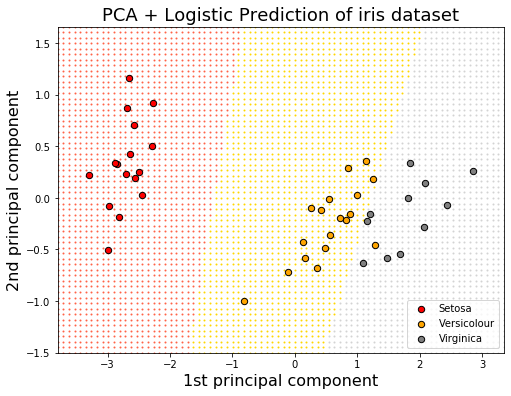

In [9]:
# plot grid predicitons and ground truths
plt.figure(figsize=(figsizex, figsizey))
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.scatter(XX[grid_id0], YY[grid_id0], s=1, color='tomato')
plt.scatter(XX[grid_id1], YY[grid_id1], s=1, color='gold')
plt.scatter(XX[grid_id2], YY[grid_id2], s=1, color='lightgray')
plt.scatter(X_val_pca[val_id0, 0], X_val_pca[val_id0, 1], c="red", edgecolor='k', s=40, label="Setosa")
plt.scatter(X_val_pca[val_id1, 0], X_val_pca[val_id1, 1], c="orange", edgecolor='k', s=40, label="Versicolour")
plt.scatter(X_val_pca[val_id2, 0], X_val_pca[val_id2, 1], c="gray", edgecolor='k', s=40, label="Virginica")
plt.title("PCA + Logistic Prediction of iris dataset", fontsize=18)
plt.xlabel("1st principal component", fontsize=16)
plt.ylabel("2nd principal component", fontsize=16)
plt.legend(loc="lower right")
plt.savefig("model-pca-logistic-predictions.png")
plt.show()

In [10]:
n_classes = len(np.unique(y))
y_binary = label_binarize(y_val, classes=range(n_classes))  # binarize outcomes for class specific analysis
fpr = dict()  # false positive rates
tpr = dict()  # true positive rates
roc_auc = dict()  # area under ROC curve

## class specific ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

## micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), y_val_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

## macro-average ROC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
sum_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    sum_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr = sum_tpr / n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

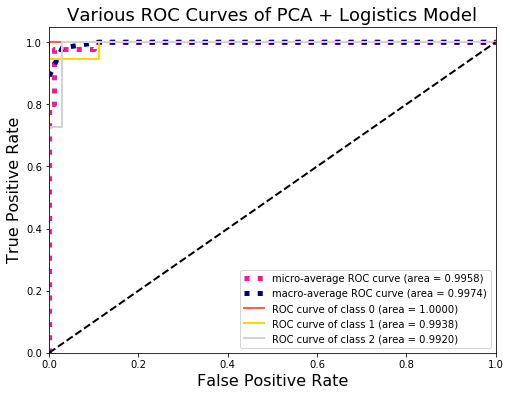

In [11]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=5)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=5)
colors = ['tomato', 'gold', 'lightgray']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Various ROC Curves of PCA + Logistics Model', fontsize=18)
plt.legend(loc="lower right")
plt.savefig("model-pca-logistic-roc.png")
plt.show()

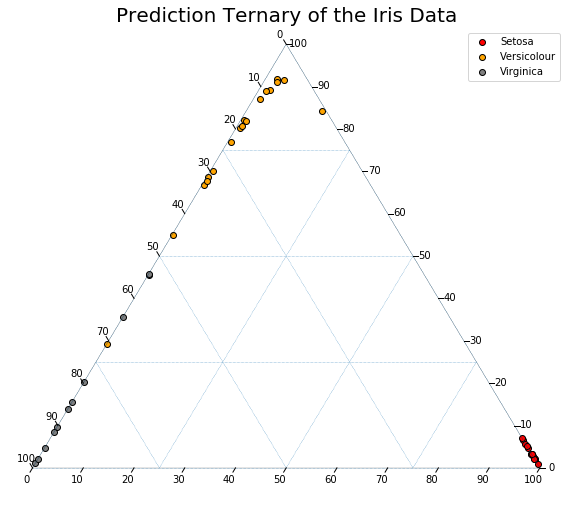

In [12]:
# ternary plot: the more pushed away towards corner the better classification prediction

probs = y_val_probs * 100  # change to percentage scale

fig, tax = ternary.figure(scale=100)
tax.boundary(linewidth=0.2)
fig.set_size_inches(10, 9)
tax.set_title("Prediction Ternary of the Iris Data", fontsize=20)
tax.scatter(probs[val_id0], edgecolor="k", color="red", label="Setosa")
tax.scatter(probs[val_id1], edgecolor="k", color="orange", label="Versicolour")
tax.scatter(probs[val_id2], edgecolor="k", color="gray", label="Virginica")
tax.legend()
tax.gridlines(multiple=25)
tax.ticks(axis='lbr', linewidth=1, multiple=10)
tax.get_axes().axis('off')
plt.savefig("model-pca-logistic-ternary.png")
tax.show()

## 2nd Approach: Neural Network

In this simple dataset, neural network (NN) might not perform as great as some straightforward approaches (like PCA+Logistic). It does not necessarily mean that NN can never have great performance. The issue is that the domain space of NN model is too large to be effectively tuning NN models, thus making it harder to find the optimal hyper-parameters set.

I include this model as a demonstration of the possibilities of NN and my knowledge for implementing these models.

#### Build Dataloader

In [13]:
class IrisDataset(Dataset):
    """Iris dataset."""

    def __init__(self, data, target):
        """
        Args:
            data (numpy.ndarray): predictors in iris dataset.
            target (numpy.ndarray): outcomes in iris dataset.
        """
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        return X, y

#### Build the Network

In [14]:
class MLP(nn.Module):
    '''A multi-layer perceptron model for iris dataset.'''
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 3)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

#### Build Functions for Train and Evaluate

In [15]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device="cpu", num_epochs=10, logfile=None):
    '''Train the model, log metrics and save the best model.'''
    # initialize
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = None
    best_loss = float("Inf")
    best_acc = 0.0
    if logfile:
        f = open(logfile, "w")
        f.write("Model: Multi-layer Perceptrons\n")
        f.write("Structure: %s\n" % model.__str__())
        f.write("Training size: %d\n" % len(dataloaders["train"].dataset))
        f.write("Evaluating size: %d\n" % len(dataloaders["val"].dataset))
    print("Model: Multi-layer Perceptrons")
    print("Structure: " + model.__str__())
    print("Training size: %d" % len(dataloaders["train"].dataset))
    print("Evaluating size: %d" % len(dataloaders["val"].dataset))
    
    # iterate over each epoch
    for epoch in range(num_epochs):
        print("\nEpoch {}/{}".format(epoch + 1, num_epochs))
        if logfile:
            f.write("\nEpoch {}/{}\n".format(epoch + 1, num_epochs))

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_correct = 0
            
            # Iterate over data
            for data, target in dataloaders[phase]:
                data = data.to(device)
                target = target.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(data)
                    loss = criterion(outputs, target)
                    correct = (outputs.argmax(dim=1) == target).sum().item()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * target.size(0)
                running_correct += correct
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_correct / len(datasets[phase]) * 100
            print("  {:7s} Loss: {:.4f}  ACC: {:.2f}%".format(phase+":", epoch_loss, epoch_acc))
            if logfile:
                f.write("  {:7s} Loss: {:.4f}  ACC: {:.2f}%\n".format(phase+":", epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_epoch = epoch + 1
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    # wrap up all epochs
    time_elapsed = time.time() - since
    print("\n" + "-" * 10)
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Loss: {:4f} at epoch {} with ACC: {:2f}%".format(best_loss, best_epoch, best_acc))
    if logfile:
        f.write("\n" + "-" * 10 + "\n")
        f.write("Training complete in {:.0f}m {:.0f}s\n".format(time_elapsed // 60, time_elapsed % 60))
        f.write("Best val Loss: {:4f} at epoch {} with ACC: {:2f}%\n".format(best_loss, best_epoch, best_acc))

    # load best model weights
    print("Load the model weights at the best epoch")
    if logfile:
        f.write("Load the model weights at the best epoch\n")
    model.load_state_dict(best_model_wts)
    f.close()
    return model

#### Training

In [16]:
# load iris dataset and train test split
iris = skdatasets.load_iris()
X = dict()
y = dict()
X["train"], X["val"], y["train"], y["val"] = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)

# torch datasets and dataloaders
datasets = {foo: IrisDataset(X[foo], y[foo]) for foo in ["train", "val"]}
dataloaders = {foo: DataLoader(datasets[foo], batch_size=16, shuffle=True) for foo in ["train", "val"]}

In [17]:
# set device to GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialize model, loss, optimizer and scheduler
NUM_EPOCHS = 100
LOGFILE = "model-MLP.txt"
model = MLP().double().to(device)
criterion = nn.CrossEntropyLoss()  # LogSoftmax + NLLLoss
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=NUM_EPOCHS//4)  # use scheduler to reduce lr during training

In [18]:
# train the model
torch.manual_seed(0)
model = train_model(model, criterion, optimizer, scheduler, dataloaders, device, num_epochs=NUM_EPOCHS, logfile=LOGFILE)
torch.save(model.state_dict(), "model-MLP.pth")

Model: Multi-layer Perceptrons
Structure: MLP(
  (fc1): Linear(in_features=4, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=3, bias=True)
)
Training size: 105
Evaluating size: 45

Epoch 1/100
  train:  Loss: 1.1278  ACC: 31.43%
  val:    Loss: 1.1575  ACC: 24.44%

Epoch 2/100
  train:  Loss: 1.1500  ACC: 22.86%
  val:    Loss: 1.1061  ACC: 24.44%

Epoch 3/100
  train:  Loss: 1.1019  ACC: 37.14%
  val:    Loss: 1.2024  ACC: 24.44%

Epoch 4/100
  train:  Loss: 1.1272  ACC: 27.62%
  val:    Loss: 1.1062  ACC: 24.44%

Epoch 5/100
  train:  Loss: 1.1108  ACC: 37.14%
  val:    Loss: 1.1420  ACC: 24.44%

Epoch 6/100
  train:  Loss: 1.1172  ACC: 30.48%
  val:    Loss: 1.0922  ACC: 35.56%

Epoch 7/100
  train:  Loss: 1.1303  ACC: 27.62%
  val:    Loss: 1.1631  ACC: 24.44%

Epoch 8/100
  train:  Loss: 1.1375  ACC: 28.57%
  val:    Loss: 1.0530  ACC: 40.00%

Epoch 9/100
  train:  Loss: 1.0820  ACC: 39.05%
  val

#### Evaluating

In [19]:
# re-construct the whole val set
X_val = []
y_val = []
for data, target in dataloaders["val"]:
    X_val.append(data.clone())
    y_val.append(target.clone())
X_val = torch.cat(X_val).to(device)
y_val = torch.cat(y_val).to(device)

# perform inference
model.eval()
with torch.no_grad():
    outcomes = model(X_val).cpu()
    y_val_preds = outcomes.argmax(dim=1).numpy()
    y_val_probs = torch.softmax(outcomes, dim=1).numpy()
    y_val = y_val.cpu().numpy()

In [20]:
# print evaluating socres
print("Evaluating:")
print("    accuracy: %.4f" % accuracy_score(y_val, y_val_preds))
print("    macro-f1 score: %.4f" % f1_score(y_val, y_val_preds, average="macro"))
print("    micro-f1 score: %.4f" % f1_score(y_val, y_val_preds, average="micro"))
print("    area uder ROC curve: %.4f" % roc_auc_score(y_val, y_val_probs, average="macro", multi_class="ovo"))

# save evaluating scores
with open("model-MLP.txt", "a") as f:
    f.write("\n" + "-" * 30 + "\n")
    f.write("Evaluating:\n")
    f.write("    accuracy: %.4f\n" % accuracy_score(y_train, y_train_preds))
    f.write("    macro-f1 score: %.4f\n" % f1_score(y_train, y_train_preds, average="macro"))
    f.write("    micro-f1 score: %.4f\n" % f1_score(y_train, y_train_preds, average="micro"))
    f.write("    area uder ROC curve: %.4f\n" % roc_auc_score(y_train, y_train_probs, average="macro", multi_class="ovo"))

Evaluating:
    accuracy: 0.9778
    macro-f1 score: 0.9760
    micro-f1 score: 0.9778
    area uder ROC curve: 0.9949


#### Evaluating Plots

In [21]:
n_classes = len(np.unique(iris.target))
y_binary = label_binarize(y_val, classes=range(n_classes))  # binarize outcomes for class specific analysis
fpr = dict()  # false positive rates
tpr = dict()  # true positive rates
roc_auc = dict()  # area under ROC curve

## class specific ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_val_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

## micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), y_val_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

## macro-average ROC
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
sum_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    sum_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr = sum_tpr / n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

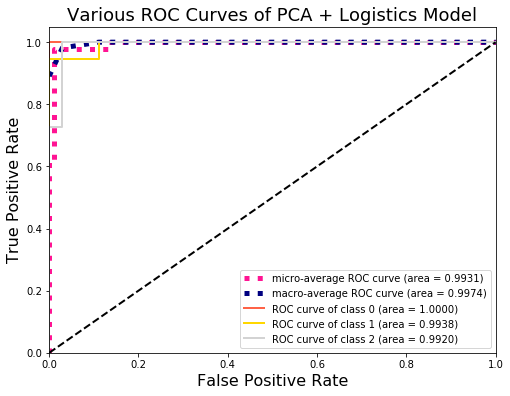

In [22]:
# Plot all ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=5)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=5)
colors = ['tomato', 'gold', 'lightgray']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Various ROC Curves of PCA + Logistics Model', fontsize=18)
plt.legend(loc="lower right")
plt.savefig("model-MLP-roc.png")
plt.show()

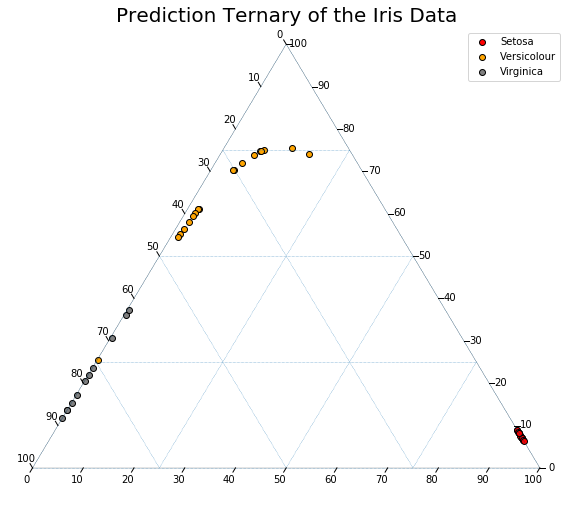

In [23]:
# ternary plot: the more pushed away towards corner the better classification prediction
probs = y_val_probs * 100  # change to percentage scale
val_id0 = np.where(y_val == 0)
val_id1 = np.where(y_val == 1)
val_id2 = np.where(y_val == 2)

fig, tax = ternary.figure(scale=100)
tax.boundary(linewidth=0.2)
fig.set_size_inches(10, 9)
tax.set_title("Prediction Ternary of the Iris Data", fontsize=20)
tax.scatter(probs[val_id0], edgecolor="k", color="red", label="Setosa")
tax.scatter(probs[val_id1], edgecolor="k", color="orange", label="Versicolour")
tax.scatter(probs[val_id2], edgecolor="k", color="gray", label="Virginica")
tax.legend()
tax.gridlines(multiple=25)
tax.ticks(axis='lbr', linewidth=1, multiple=10)
tax.get_axes().axis('off')
plt.savefig("model-MLP-ternary.png")
tax.show()